## INTRODUCTION

On cherche à créer un programme python permettant de tracer des lignes de niveau d'une fonction $f:\mathbb{R}^2\to\mathbb{R}\$

Pour cela on choisit de, plutôt que de traiter le cas plus complexe d'une ligne de niveau dans un pavé de grande dimension, on va dans un premier temps se concentrer sur le cas du carré unité $\mathopen{[}0,1\mathclose{]}^2$. Il suffira d'étendre le programme de calcul dans ce carré au reste des carrés de la forme $\mathopen{[}a,a+1\mathclose{]}^2,a\in\mathbb{R}$ pavant le domaine de définition de $f$.

On va tout d'abord importer les modules auxquels on fera appel lors de la conception des programmes:

In [1]:
import matplotlib.pyplot as plt
from math import *
import numpy as np

# Amorce:

On demande d'abord une condition *raisonnable* sur $f(0,0),\: f(0,1)$ et $c\:(c\in\mathbb{R})$ telle que: $\exists\:t\in\mathopen{[}0,1\mathclose{]}$ tq $f(0,t)=c$


>Une condition suffisante (bien que relativement exigente) est donnée par le théorème des valeurs intermédiaires, qui s'exprime de la manière suivante:

>Soient $(a,b,c)\in\mathbb{R}^3,\: et\: f:\mathopen{[}a,b\mathclose{]}\to\mathbb{R}$ continue sur son intervalle de définition. Si $c\in f(\mathopen{[}a,b\mathclose{]})$ alors $\exists\ t\in\mathopen{[}a,b\mathclose{]}$ tel que $f(t)=c$

>Ainsi, on choisit la condition suffisante suivante: $c\in f(\mathopen{[}0,1\mathclose{]}$


# Question 1

On demande d'en déduire une fonction ```find_seed``` permettant d'initialiser notre recherche d'une ligne de niveau sur l'arrête droite du carré unité:
>On choisit d'utiliser la méthode de la dichotomie, qui permet d'obtenir une approximation à $\:2^{-26}$ de la valeur c recherchée (la valeur $2^{-26}$ étant fixée par l'énoncé). Cette méthode a l'avantage d'être relativement rapide (complexité en O(ln(n)).

On obtient le code suivant:

In [2]:
def find_seed (g,a=0,b=1,c=0,eps=2**(-26)):
    #on vérifie qu'il existe une solution
    if not (min(g(a),g(b))<=c<=max(g(a),g(b))):
        return None
    t=(a+b)/2
    while abs(b-a)>eps:
        for x in [a,b,t]:
            if g(x)==0:
                return x
        if g(a)*g(t)<0:
            b=t
        else:
            a=t
        t=(a+b)/2
    return t

On présente ici la version finale du code, qui permettra à terme non pas de trouver le début d'une ligne de niveau sur une arrête droite du carré unité mais le début d'une ligne de niveau sur n'importe quelle arrête de n'importe quel carré de la forme $\mathopen{[}a,b\mathclose{]}$

# Question 2

On demande maintenant d'écrire une fonction ```contour_simple``` permettant de tracer une ligne de niveau dans un carré unité.

Pour cela on va utiliser une méthode qui n'a pas recours à l'exploitation du gradient de $f$, et qui donc n'appelera pas la fonction ```autograd.grad```. En effet cette méthode plus rapide a cependant un désavantage: une forte propagation des erreurs (qu'on retrouve dans le cas 1D dans la forte propagation de l'erreur dans l'algorithme de la méthode de Newton).


Voici le code, d'abord de la première fonction codée, relativement "naïve":

In [3]:
#première méthode naïve, fonctionnant par dichotomie en appelant find_seed pour chaque argument x:

def simple_contour(f,c=0.0, delta=0.01):
    listex=np.arange(0,1,delta)
    listey=[]
    for x in listex : 
        def g(a):
            return f(x,a)
        y=find_seed(g)
        if y==None:
            return [],[]
        listey+=[y]
    return listex,listey

La méthode que l'on va réllement utiliser est une recherche de ligne de niveau de proche en proche. Partant d'un point dont on sait qu'il appartient à la ligne de niveau à tracer, on cherche dans un cercle de rayon delta autour du point un autre point appartenant à la ligne de niveau. 

On s'attend à ce que cette méthode soit plutôt lente en temps d'exécution, mais qu'elle soit presque libre de problèmes de propagation d'erreur, puisqu'on recherche une solution approchée indépendante de la solution trouvée à la recherche précédente.

On essaye tout d'abord en parcourant tout le cercle, mais on a trop de risques de retour en arrière et c'est très long.
(remarque : la fonction est adaptée pour la suite de l'exercice, et prend donc en argument n, qui correspond au coté sur le quel on cherche la seed (1:gauche, 2:haut, etc), ainsi que xp et yp les intervalles de x et de y)

On décide donc de se servir de la tangente que l'on évalue grâce aux deux derniers points pour avoir la normale et pouvoir connaître la moitié du cercle qu'il faut chercher.

On va se servir d'une fonction auxilliaire: ```angle```

In [4]:
def angle(tangente):
    c,d=tangente
    if c==0:
        return 0,pi,0
    #on calcule teta0, l'angle que fait la tangente avec l'abscisse.
    if c<0:
        teta0=atan(d/c)+pi
    else:
        teta0=atan(d/c)
    #on calcule teta2 et teta1, le secteur angulaire de recherche. On retourne teta2 en premier, qui correspond à l'angle où commencera la recherche qui se poursuivra dans le sens trigo.
    teta2=teta0-pi/2
    teta1=teta0+pi/2
    return teta2,teta1,teta2

In [5]:
def simple_contour(f,n=1,xp=[0,1],yp=[0,1],c=0,delta=0.01):
    #on définit g la fonction d'une variable que l'on obtient en fixant x ou y dans f fonction de (x,y),
    #selon le coté par lequel on arrive, à la bonne valeur (ex pour n=1 : on fixe x à xp[0])
    def g(a):
        if n==1:
            return f(xp[0],a)
        if n==2:
            return f(a,yp[1])
        if n==3:
            return f(xp[1],a)
        return f(a,yp[0])
    #pour chaque valeur de n:
        #on trouve le point de départ, en vérifiant qu'il existe bien.
        #on définit le secteur angulaire de recherche du point suivant, en traitant les cas où on est trop proche des bords.
        #s permet de régler le sens dans lequel on va tourner pour la recherche du point suivant.
    seed1=find_seed(g,xp[0],xp[1])
    seed2=find_seed(g,yp[0],yp[1])
    if n==1:
        seed=seed2
        point=[xp[0],seed]
        if point[1]==None or point[0]==None:
            return [],[]
        teta1,teta2=-pi/2,pi/2
        if seed<yp[0]+delta:
            teta1=0
        if seed>yp[1]-delta:
            teta2=0
        s=-1
    if n==2:
        seed=seed1
        point=[seed,yp[1]]
        if point[1]==None or point[0]==None:
            return [],[]
        teta1,teta2=-pi,0
        if seed<xp[0]+delta:
            teta1=-pi/2
        if seed>xp[1]-delta:
            teta2=-pi/2
        s=-1
    if n==3:
        seed=seed2
        point=[xp[1],seed]
        if point[1]==None or point[0]==None:
            return [],[]
        teta1,teta2=-pi/2,-3*pi/2
        if seed<yp[0]+delta:
            teta1=-pi
        if seed>yp[1]-delta:
            teta2=-pi
        s=1
    if n==4:
        seed=seed1
        point=[seed,yp[0]]
        if point[1]==None or point[0]==None:
            return [],[]
        teta1,teta2=-pi,-2*pi
        if seed<xp[0]+delta:
            teta1=-pi/2
        if seed>xp[1]-delta:
            teta2=-pi/2
        s=1
    teta=teta2
    #on créé les listees que l'on va retourner, qui ne contiennent initialement que l'abscisse et l'ordonnée du point de départ, puis on cherche le point suivant.
    u,v=point[0],point[1]
    lx,ly=[u],[v]
    eps=1*10**-4
    x,y=u+delta*cos(teta),v+delta*sin(teta)
    while abs(f(x,y)-c)>eps and s*teta2<=s*teta<=s*teta1:
        teta+=s*eps
        x,y=u+delta*cos(teta),v+delta*sin(teta)
    lx+=[x]
    ly+=[y]
    #on va rechercher tous les points suivants en s'aidant de la tangente, tant qu'on ne sort pas du carré.
    while xp[0]<=lx[-1]<=xp[1] and yp[0]<=ly[-1]<=yp[1]:
        u,v=lx[-1],ly[-1]
        tangente=[u-lx[-2],v-ly[-2]]
        teta,teta1,teta2=angle(tangente)
        x,y=u+delta*cos(teta),v+delta*sin(teta)
        while abs(f(x,y)-c)>eps and teta2<=teta<=teta1:
            teta+=eps
            x,y=u+delta*cos(teta),v+delta*sin(teta)
        #dans le cas où on n'a pas trouvé de teta, on retourne des listes vides.
        if abs(f(x,y)-c)>eps:
            return [],[]
        lx+=[x]
        ly+=[y]
    return lx,ly

Cette méthode est beaucoup trop lente. On décide donc de chercher le point suivant en partant de la tangente, et en s'en éloignant des deux cotés.

Pour cela, on modifie légérement la fonction angle.

De plus, on ajoute une liste ln dans les listes à retourner, qui contient le coté par lesquels on est sorti. Dans le cas où l'on rentre où l'on sort par l'un des angles, les deux cotés (sauf éventuellement celui par lequel il était prévu d'entrer) sont aussi ajoutés dans la liste.

Ainsi, on pourra éviter de reparcourir la courbe dans plusieurs sens ou plusieurs fois.

In [6]:
def angle(tangente):
    c,d=tangente
    if c==0:
        return 0,pi,0
    if c<0:
        teta0=atan(d/c)+pi
    else:
        teta0=atan(d/c)
    teta2=teta0-pi/2
    teta1=teta0+pi/2
    #maintenant, l'angle point de départ est teta0.
    return teta0,teta1,teta2

def simple_contour(f,n=1,xp=[0,1],yp=[0,1],c=0,delta=0.01):
    def g(a):
        if n==1:
            return f(xp[0],a)
        if n==2:
            return f(a,yp[1])
        if n==3:
            return f(xp[1],a)
        return f(a,yp[0])
    seed1=find_seed(g,xp[0],xp[1])
    seed2=find_seed(g,yp[0],yp[1])
    ln=[]
    if n==1:
        seed=seed2
        point=[xp[0],seed]
        if point[1]==None or point[0]==None:
            return [],[]
        teta1,teta2=-pi/2,pi/2
        if seed<yp[0]+delta:
            teta1=0
            ln+=[4]
        if seed>yp[1]-delta:
            teta2=0
            ln+=[2]
        s=-1
    if n==2:
        seed=seed1
        point=[seed,yp[1]]
        if point[1]==None or point[0]==None:
            return [],[]
        teta1,teta2=-pi,0
        if seed<xp[0]+delta:
            teta1=-pi/2
            ln+=[1]
        if seed>xp[1]-delta:
            teta2=-pi/2
            ln+=[3]
        s=-1
    if n==3:
        seed=seed2
        point=[xp[1],seed]
        if point[1]==None or point[0]==None:
            return [],[]
        teta1,teta2=-pi/2,-3*pi/2
        if seed<yp[0]+delta:
            teta1=-pi
            ln+=[4]
        if seed>yp[1]-delta:
            teta2=-pi
            ln+=[2]
        s=1
    if n==4:
        seed=seed1
        point=[seed,yp[0]]
        if point[1]==None or point[0]==None:
            return [],[]
        teta1,teta2=-pi,-2*pi
        if seed<xp[0]+delta:
            teta1=-pi/2
            ln+=[1]
        if seed>xp[1]-delta:
            teta2=-pi/2
            ln+=[3]
        s=1
    teta=teta2
    u,v=point[0],point[1]
    lx,ly=[u],[v]
    eps=1*10**-4
    x,y=u+delta*cos(teta),v+delta*sin(teta)
    while abs(f(x,y)-c)>eps and s*teta2<=s*teta<=s*teta1:
        teta+=s*eps
        x,y=u+delta*cos(teta),v+delta*sin(teta)
    lx+=[x]
    ly+=[y]
    while xp[0]<=lx[-1]<=xp[1] and yp[0]<=ly[-1]<=yp[1]:
        u,v=lx[-1],ly[-1]
        teta,teta1,teta2=angle([u-lx[-2],v-ly[-2]])
        teta0=teta
        #tetap va évoluer dans le sens anti-trigo, teta0 dans le sens trigo.
        #x2,y2 seront les points du cercle d'argument tetap.
        tetap=teta
        x,y=u+delta*cos(teta),v+delta*sin(teta)
        x2,y2=x,y
        while (abs(f(x,y)-c)>eps and teta0<=teta<=teta1) and (abs(f(x2,y2)-c)>eps and teta2<=tetap<=teta0):
            teta+=eps
            tetap-=eps
            x,y=u+delta*cos(teta),v+delta*sin(teta)
            x2,y2=u+delta*cos(tetap),v+delta*sin(tetap)
        if abs(f(x,y)-c)>eps and abs(f(x2,y2)-c)>eps:
            return [],[]
        if abs(f(x2,y2)-c)<eps:
            lx+=[x2]
            ly+=[y2]
        else :
            lx+=[x]
            ly+=[y]
    #on augmente n en fonction du point de sortie.
    if abs(lx[-1]-xp[0])<delta:
        ln+=[1]
    if abs(lx[-1]-xp[1])<delta:
        ln+=[3]
    if abs(ly[-1]-yp[0])<delta:
        ln+=[4]
    if abs(ly[-1]-yp[1])<delta:
        ln+=[2]
    return lx,ly,ln

# Question 3

On demande ensuite d'écrite une fonction ```contour complexe``` qui trace la ligne de niveau sur l'ensemble de l'espace.

Il s'agit donc de découper l'espace en carré unités. Il suffira d'appeler contour simple dans chacun des carrés.


In [7]:
def contour(f,c=0.0,xc=[-2,-1,0,1,2],yc=[-1,0,1],delta=0.01):
    xs,ys=[],[]
    #a désigne la "colonne" dans laquelle on est, b la "ligne". On s'arrange pour parcourir tous les carrés.
    for a in range(len(xc)-1):
        for b in range(len(yc)-1):
            xp=[xc[a],xc[a+1]]
            yp=[yc[b],yc[b+1]]
            #pour chaque carré, on se prépare à étudier chaque coté.
            liste=[1,2,3,4]
            for n in liste:
                vect=simple_contour(f,n,xp,yp)
                xs+=[vect[0]]
                ys+=[vect[1]]
                #on regarde maintenant quelles valeurs on peut enlever à liste.
                if len(vect)>2:
                    for x in vect[2]:
                        try :
                            liste.pop(x)
                        except:
                            None
    return xs,ys

On teste la fonction contour pour quelques fonctions quadratiques 

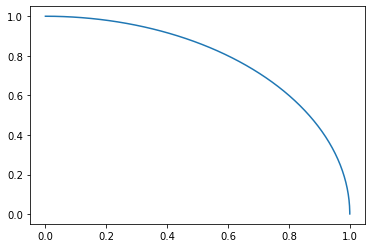

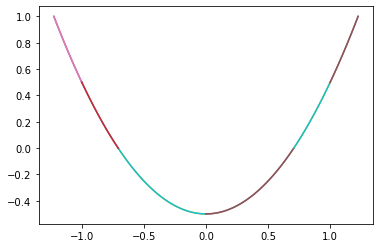

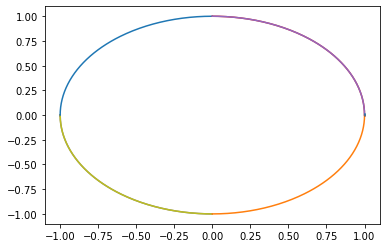

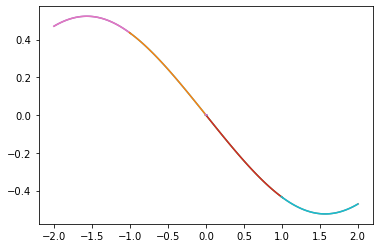

In [9]:

def quadra(x,y):
    return x**2+y**2-1
def quadra2(x,y):
    return y-x**2+.5
def f(x,y):
    return np.sin(x)+2*np.sin(y)

l=simple_contour(quadra)
x,y=l[0],l[1]
plt.plot(x,y)
plt.show()

plt.figure()
xs,ys=contour(quadra2)
for x,y in zip(xs,ys):
    plt.plot(x,y)
plt.show()

plt.figure()
xs,ys=contour(quadra)
for x,y in zip(xs,ys):
    plt.plot(x,y)
plt.show()
plt.figure()
xs,ys=contour(f)
for x,y in zip(xs,ys):
    plt.plot(x,y)
plt.show()

Ce qui donne en un temps respectable le résultat escompté